In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

# EUCTR

In [3]:
#loading data and converting to datetime
may_19 = pd.read_csv('euctr_may19.csv')

for date in ['date_of_competent_authority_decision', 
             'date_of_ethics_committee_opinion', 
             'date_on_which_this_record_was_first_entered_in_the_eudract_data']:
    may_19[date] = pd.to_datetime(may_19[date], errors='coerce')
may_19.head()

,eudract_number,eudract_number_with_country,trial_location,date_of_competent_authority_decision,date_of_ethics_committee_opinion,date_on_which_this_record_was_first_entered_in_the_eudract_data,phase_1
0,2004-002902-31,2004-002902-31-MT,MT,2006-08-18,2006-09-07,2006-08-21,0
1,2006-000009-51,2006-000009-51-SI,SI,2009-11-12,2009-11-09,2009-09-04,0
2,2009-018054-33,2009-018054-33-SI,SI,2010-06-21,2009-01-19,2010-04-09,0
3,2007-001283-73,2007-001283-73-SI,SI,2007-06-07,2007-05-15,2007-06-04,0
4,2008-002782-32,2008-002782-32-IS,IS,2009-01-09,2008-12-02,2008-11-06,0


In [4]:
#Getting an overview of all trials be country on the EUCTR
trial_counts = may_19['eudract_number'].groupby(may_19.trial_location).count()
trial_counts

trial_location
3rd     1237
AT      3812
BE      5425
BG      1653
CZ      3937
DE     10422
DK      3609
EE       965
ES      8627
FI      2361
FR      4815
GB      8756
GR      1569
HR       276
HU      4024
IE      1077
IS       132
IT      7100
LT      1159
LU         7
LV       998
MT        18
NL      4965
NO       533
PL      2634
PT      1391
RO       227
SE      3642
SI       350
SK      1656
Name: eudract_number, dtype: int64

In [5]:
#This function gets the data in a place where you can graph it.
#Options:
#quarters = True will group the data per quarter. If this is False, you will get it by year.
#small_filter = True filters out countries with less than 1000 total trials on EUCTR as a default.
#You can adjust what "small" is by optionally changing the interger value of "small_def"
#thrd_filter = True will filter out all trial locations in a non EU country
#p1_filter is defaulted to true which removes all trials listed as ONLY phase 1 trials (i.e. not phase1/2)
#bad date data for any field is coerced to NaN

def process_data(data, quarters=False, small_filter=False, small_def=1000, thrd_filter=False, p1_filter=True):
    excluded_list = []
    start_quarter = pd.to_datetime('2008-01').to_period('Q')
    end_quarter = pd.to_datetime('2019-01').to_period('Q')
    if small_filter:
        trial_counts = data['eudract_number'].groupby(data.trial_location).count()
        x = list(trial_counts[trial_counts < small_def].index)
        excluded_list = excluded_list + x
    if thrd_filter:
        excluded_list.append('3rd')             
    data = data[~data.trial_location.isin(excluded_list)].reset_index(drop=True)
    if p1_filter:
        data = data[data.phase_1 == 0].reset_index(drop=True)
    data['date_of_competent_authority_decision'] = pd.to_datetime(data['date_of_competent_authority_decision'], errors='coerce')
    data['date_of_ethics_committee_opinion'] = pd.to_datetime(data['date_of_ethics_committee_opinion'], errors='coerce')
    data['date_on_which_this_record_was_first_entered_in_the_eudract_data'] = pd.to_datetime(data['date_on_which_this_record_was_first_entered_in_the_eudract_data'], errors='coerce')
    if not quarters:
        cad = data['eudract_number'].groupby([data.trial_location, data.date_of_competent_authority_decision.dt.year]).count()
        ethics = data['eudract_number'].groupby([data.trial_location, data.date_of_ethics_committee_opinion.dt.year]).count()
        entered = data['eudract_number'].groupby([data.trial_location, data.date_on_which_this_record_was_first_entered_in_the_eudract_data.dt.year]).count()
    elif quarters:
        cad = data['eudract_number'].groupby([data.trial_location, pd.PeriodIndex(data.date_of_competent_authority_decision, freq='Q')]).count()
        ethics = data['eudract_number'].groupby([data.trial_location, pd.PeriodIndex(data.date_of_ethics_committee_opinion, freq='Q')]).count()
        entered = data['eudract_number'].groupby([data.trial_location, pd.PeriodIndex(data.date_on_which_this_record_was_first_entered_in_the_eudract_data, freq='Q')]).count()
    combined = pd.concat([cad,ethics,entered], axis=1)
    combined.columns = ['cad', 'ethics', 'entered']
    if quarters:
        combined.index.names = ['country', 'quarters']
        combined = combined.query('quarters < @end_quarter')
        combined = combined.query('quarters >= @start_quarter')
        time_i = combined.index.get_level_values(1)
    elif not quarters:
        combined.index.names = ['country', 'years']
        combined = combined.query('years < 2019')
        combined = combined.query('years >= 2008')
        time_i = combined.index.get_level_values(1).astype(int) 
    country_i = combined.index.get_level_values(0).astype(str)
    combined.index = [country_i, time_i]
    if not quarters:
        pivoted_cad = combined.reset_index().pivot('years','country','cad').fillna(0)
        pivoted_ethics = combined.reset_index().pivot('years','country','ethics').fillna(0)
        pivoted_entered = combined.reset_index().pivot('years','country','entered').fillna(0)
    elif quarters:
        pivoted_cad = combined.reset_index().pivot('quarters','country','cad').fillna(0)
        pivoted_cad.index = pivoted_cad.index.to_timestamp()
        pivoted_ethics = combined.reset_index().pivot('quarters','country','ethics').fillna(0)
        pivoted_ethics.index = pivoted_ethics.index.to_timestamp()
        pivoted_entered = combined.reset_index().pivot('quarters','country','entered').fillna(0)
        pivoted_entered.index = pivoted_entered.index.to_timestamp()
    return pivoted_cad, pivoted_ethics, pivoted_entered

In [6]:
#The data for graphing for only large countries in quarters and years
pivoted_cad_q, pivoted_ethics_q, pivoted_entered_q = process_data(may_19, quarters=True, small_filter=True, thrd_filter=True)
pivoted_cad, pivoted_ethics, pivoted_entered = process_data(may_19, quarters=False, small_filter=True, thrd_filter=True)

In [7]:
#The data for graphing for all countries in quarters and years
all_pivoted_cad_q, all_pivoted_ethics_q, all_pivoted_entered_q = process_data(may_19, quarters=True, small_filter=False, thrd_filter=True)
all_pivoted_cad, all_pivoted_ethics, all_pivoted_entered = process_data(may_19, quarters=False, small_filter=False, thrd_filter=True)

In [8]:
#Checking the data
pivoted_cad.head()

country,AT,BE,BG,CZ,DE,DK,ES,FI,FR,GB,GR,HU,IE,IT,LT,NL,PL,PT,SE,SK
years,,,,,,,,,,,,,,,,,,,,
2008,223.0,430.0,165.0,263.0,862.0,241.0,565.0,191.0,701.0,727.0,101.0,250.0,80.0,751.0,104.0,394.0,113.0,123.0,309.0,139.0
2009,344.0,392.0,138.0,272.0,861.0,246.0,589.0,180.0,693.0,725.0,126.0,263.0,73.0,660.0,70.0,392.0,113.0,97.0,283.0,127.0
2010,325.0,373.0,138.0,269.0,804.0,194.0,538.0,176.0,485.0,625.0,110.0,260.0,81.0,574.0,70.0,354.0,119.0,98.0,229.0,121.0
2011,283.0,358.0,163.0,310.0,841.0,251.0,622.0,146.0,141.0,631.0,112.0,305.0,60.0,562.0,93.0,300.0,165.0,82.0,265.0,152.0
2012,268.0,391.0,144.0,292.0,711.0,243.0,629.0,146.0,104.0,671.0,136.0,313.0,67.0,583.0,72.0,375.0,269.0,89.0,233.0,126.0


In [10]:
#This function prepares which countries you would like to graph
#It outputs a list of country abbreviations depending on the total_trials amount and whether you want greater or less than
#thrd_filter removes trials from non EU countries.

def which_countries(data, total_trials, greater_than=True, thrd_filter = True):
    inc_states = []
    trial_counts = data['eudract_number'].groupby(data.trial_location).count()
    if greater_than:
        inc = list(trial_counts[trial_counts > total_trials].index)
        inc_states = inc_states + inc
    elif not greater_than:
        inc = list(trial_counts[trial_counts < total_trials].index)
        inc_states = inc_states + inc
    if thrd_filter and '3rd' in inc_states:
        inc_states.remove('3rd')
    return inc_states
included = which_countries(may_19, 4000)

In [11]:
#importing seaborn for color palettes
import seaborn as sns

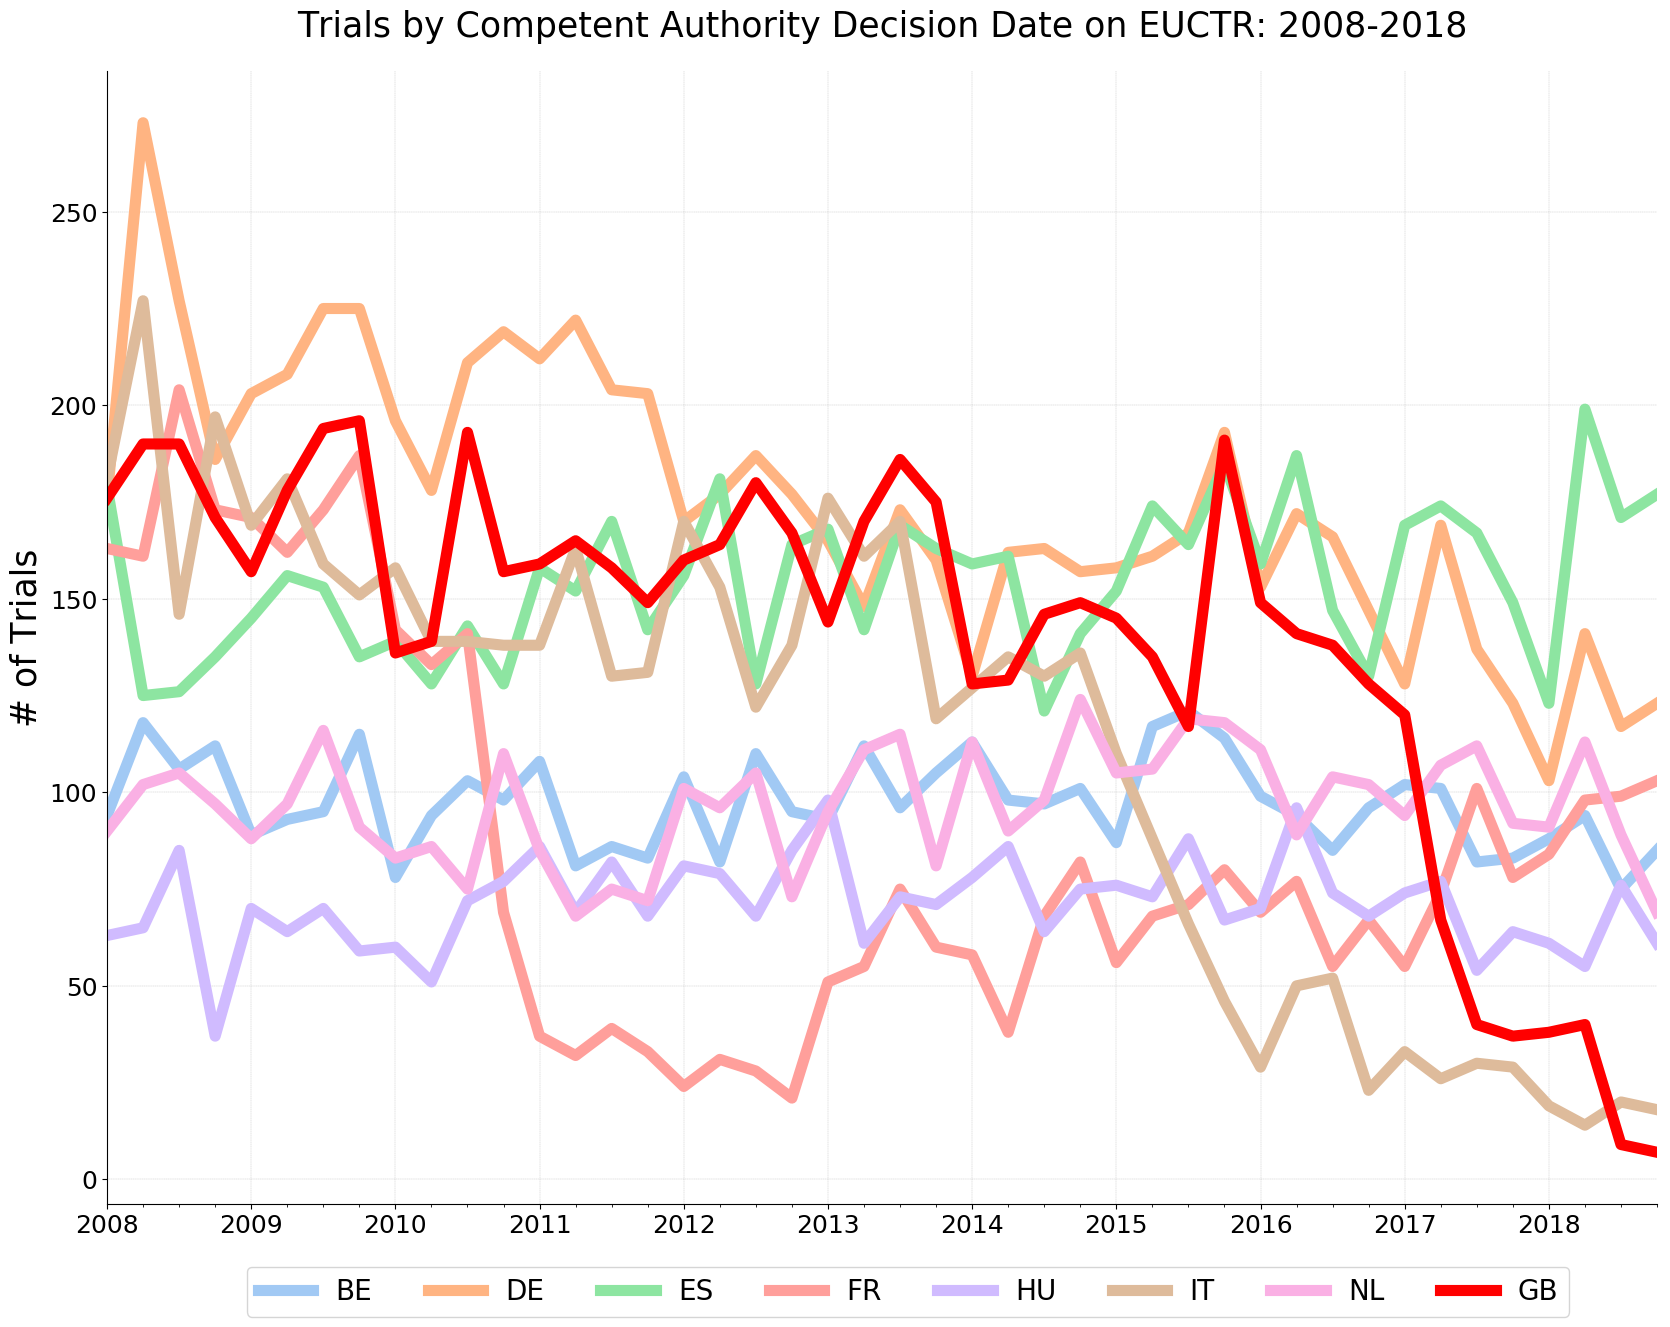

In [15]:
# Reorder the columns by count in the last year
df = pivoted_cad_q[included]
cols = list(df.columns)

# Put GB at the top
cols.remove("GB")
cols.append("GB")
df = df.reindex(cols, axis=1)

colors = sns.color_palette("pastel",n_colors=len(cols))


colors[cols.index('GB')] = 'r'

#Graph by quarters
fig, ax = plt.subplots(figsize=(20,15), dpi = 100)
df.plot(ax=ax, linewidth=8, color=colors)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.title("Trials by Competent Authority Decision Date on EUCTR: 2008-2018", pad=25, fontsize=25)
ax.xaxis.set_label_text('')
ax.yaxis.set_label_text('# of Trials', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc=(.09,-.1), ncol = 8, fontsize = 20)
ax.yaxis.grid(linestyle='--', linewidth=.25)
ax.xaxis.grid(linestyle='--', linewidth=.25)
plt.show()

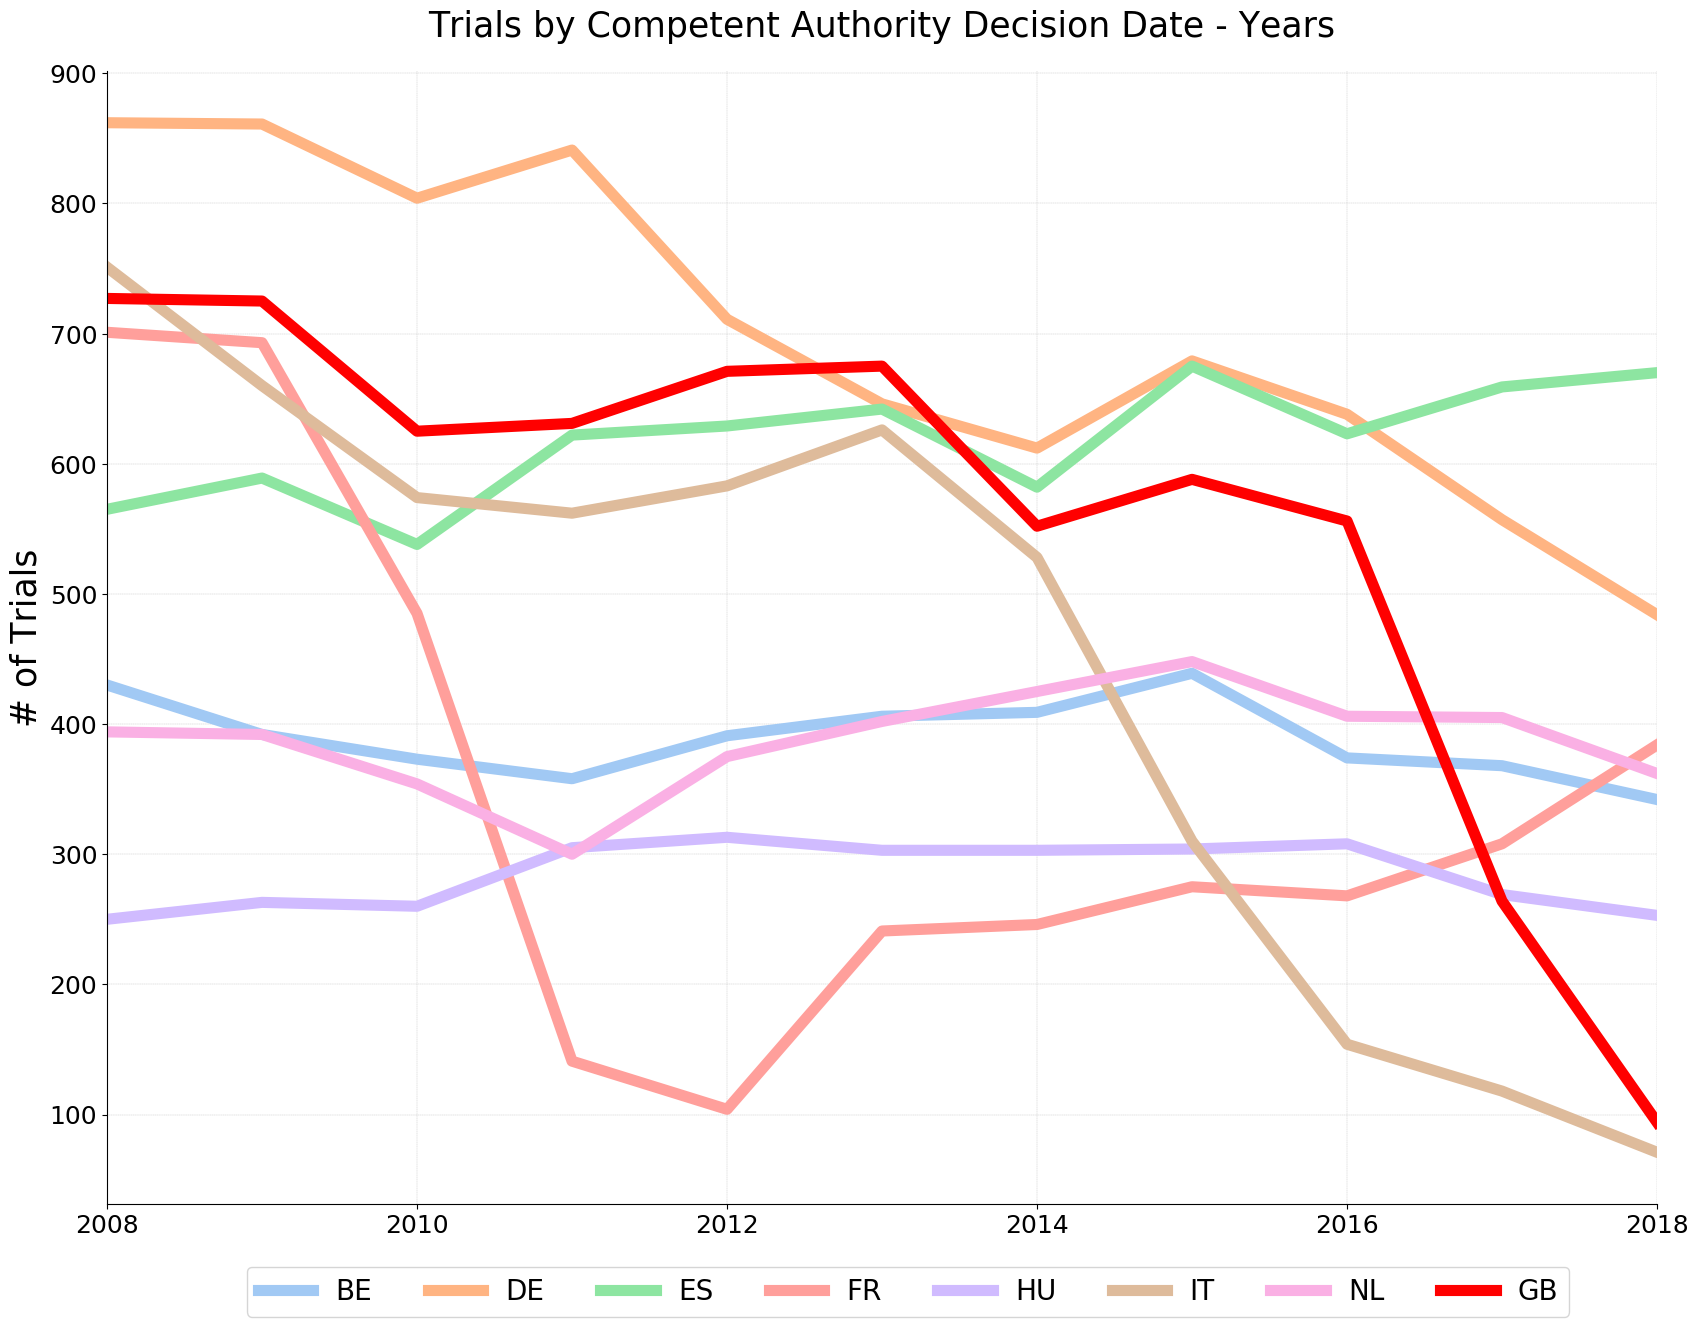

In [17]:
# Reorder the columns by count in the last year
df = pivoted_cad[included]
cols = list(df.columns)

# Put GB at the top
cols.remove("GB")
cols.append("GB")
df = df.reindex(cols, axis=1)

colors = sns.color_palette("pastel",n_colors=len(cols))


colors[cols.index('GB')] = 'r'

#Graph by years
fig, ax = plt.subplots(figsize=(20,15), dpi = 100)
df.plot(ax=ax, linewidth=8, color=colors)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.title("Trials by Competent Authority Decision Date - Years", pad=25, fontsize=25)
ax.xaxis.set_label_text('')
ax.yaxis.set_label_text('# of Trials', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc=(.09,-.1), ncol = 8, fontsize = 20)
ax.yaxis.grid(linestyle='--', linewidth=.25)
ax.xaxis.grid(linestyle='--', linewidth=.25)
plt.show()

# ClinicalTrials.gov

In [18]:
ctgov = pd.read_csv('ctgv_trends.csv')

C:\Users\ndevito\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3044: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
#Making dates datetime
for date in ['start_date', 'submitted_date']:
    ctgov[date] = pd.to_datetime(ctgov[date], errors='coerce')

In [20]:
#Ensuring the data loaded correctly
ctgov.head()

,nct_id,study_status,study_type,start_date,submitted_date,location,phase
0,NCT00006444,Completed,Observational,2000-11-30,2000-11-03,"{""country"":[""Puerto Rico"",""United States""]}",NaN
1,NCT00006435,Completed,Observational,2000-10-29,2000-11-03,"{""country"":""United States""}",NaN
2,NCT00006440,Completed,Observational,2000-03-31,2000-11-03,"{""country"":""United States""}",NaN
3,NCT00006442,Completed,Observational,NaT,2000-11-03,"{""country"":""United States""}",NaN
4,NCT00006437,Completed,Observational,2000-10-31,2000-11-03,"{""country"":""United States""}",NaN


In [21]:
#Prepared the ClinicalTrials.gov data for graphing
#Options:
#data is your dataset
#country is a string of the country you would like to get counts for. This must match the name as provided in the "location" column
#quarters changes between grouping between year and quarter
#times is a list of year strings that let you control what appears in the dataset
#p1_filter takes out phase 1 trials of =True

def process_ctdata(data, country, quarters = False, times=['2012', '2019'], p1_filter=True):
    start_quarter = pd.to_datetime(times[0] + '-01').to_period('Q')
    end_quarter = pd.to_datetime(times[1] + '-01').to_period('Q')          
    data = data[data.location.str.contains(country, na = False, regex = False)].reset_index(drop=True)
    if p1_filter:
        data = data[~((data.phase == "Early Phase 1") | (data.phase == "Phase 1"))].reset_index(drop=True)
    if not quarters:
        start = data['nct_id'].groupby(data.start_date.dt.year).count()
        submitted = data['nct_id'].groupby(data.submitted_date.dt.year).count()
    elif quarters:
        start = data['nct_id'].groupby(pd.PeriodIndex(data.start_date, freq='Q')).count()
        submitted = data['nct_id'].groupby(pd.PeriodIndex(data.submitted_date, freq='Q')).count()
    combined = pd.concat([start, submitted], axis=1)
    combined.columns = ['start', 'submitted']
    if quarters:
        combined.index.names = ['quarters']
        combined = combined.query('quarters < @end_quarter')
        combined = combined.query('quarters >= @start_quarter')
    elif not quarters:
        combined.index.names = ['years']
        combined = combined.query('years < {}'.format(times[1]))
        combined = combined.query('years >= {}'.format(times[0]))
    return combined

In [22]:
#Helper function for graphing 2 countries against one another
def graph(title, data1, data2):
    fig, ax = plt.subplots(figsize=(25,10), dpi = 100)
    data1.plot(ax=ax, linewidth=8, color='red')
    data2.plot(ax=ax, linewidth=8, color='blue')
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.title(title, pad=25, fontsize=25)
    ax.xaxis.set_label_text('')
    ax.yaxis.set_label_text('# of Trials', fontsize=25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(labels = ['United Kingdom', 'France'], loc='upper left', fontsize = 30)
    ax.yaxis.grid(linestyle='--', linewidth=.25)
    ax.xaxis.grid(linestyle='--', linewidth=.25)
    plt.show()

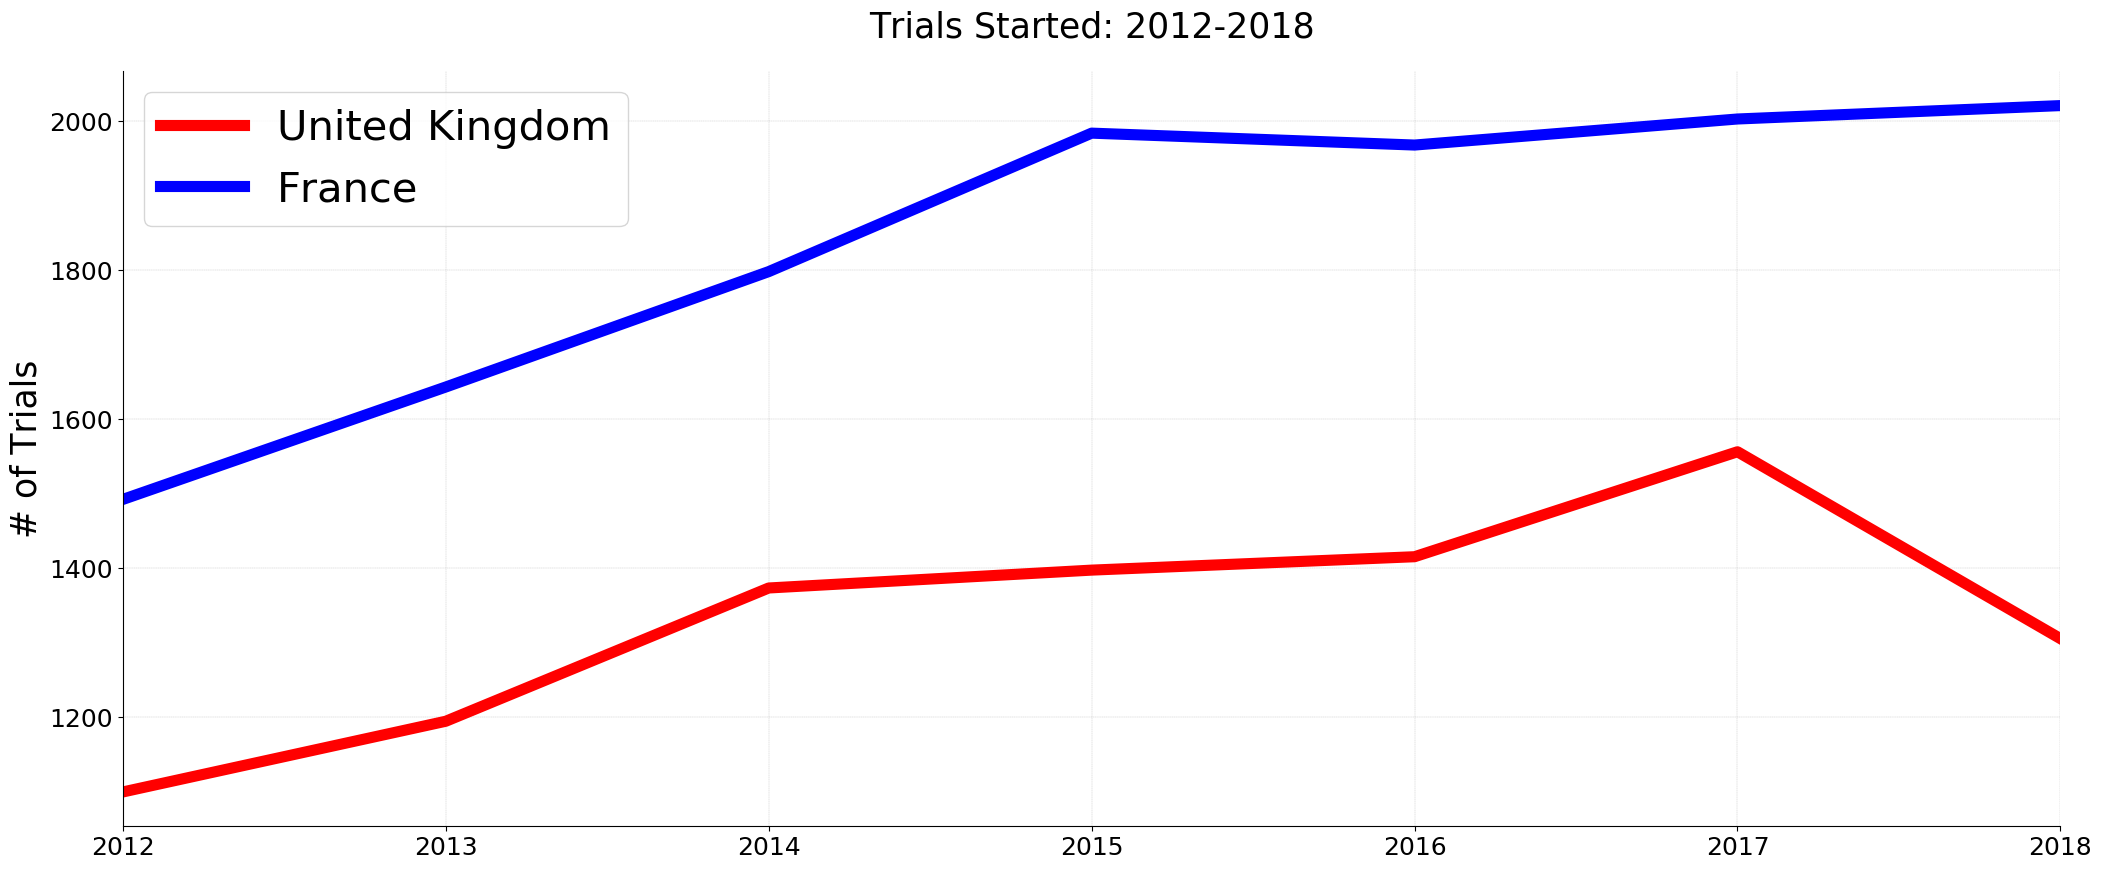

In [23]:
start_date_year = "Trials Started: 2012-2018"
uk = process_ctdata(ctgov,'United Kingdom', p1_filter=False)
fr = process_ctdata(ctgov,'France', p1_filter=False)
graph(start_date_year, uk.start, fr.start)

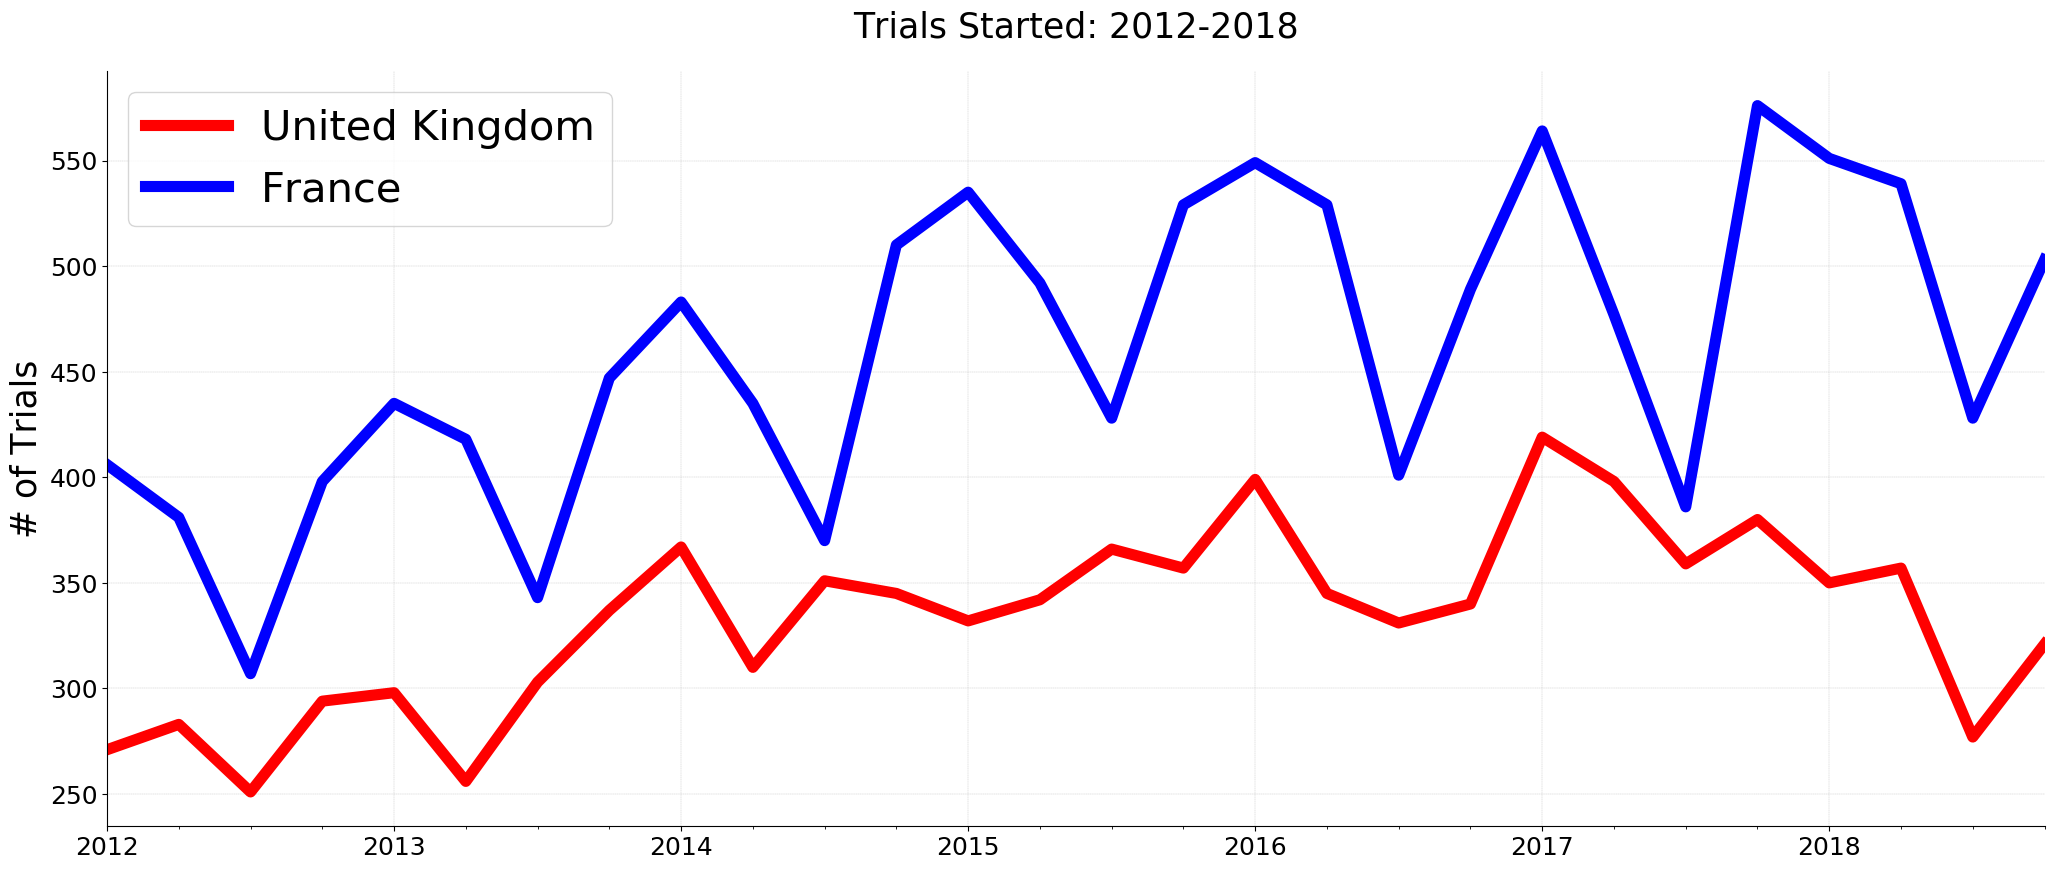

In [24]:
uk_q = process_ctdata(ctgov,'United Kingdom', quarters=True, p1_filter=False)
fr_q = process_ctdata(ctgov,'France', quarters=True, p1_filter=False)
graph(start_date_year, uk_q.start, fr_q.start)

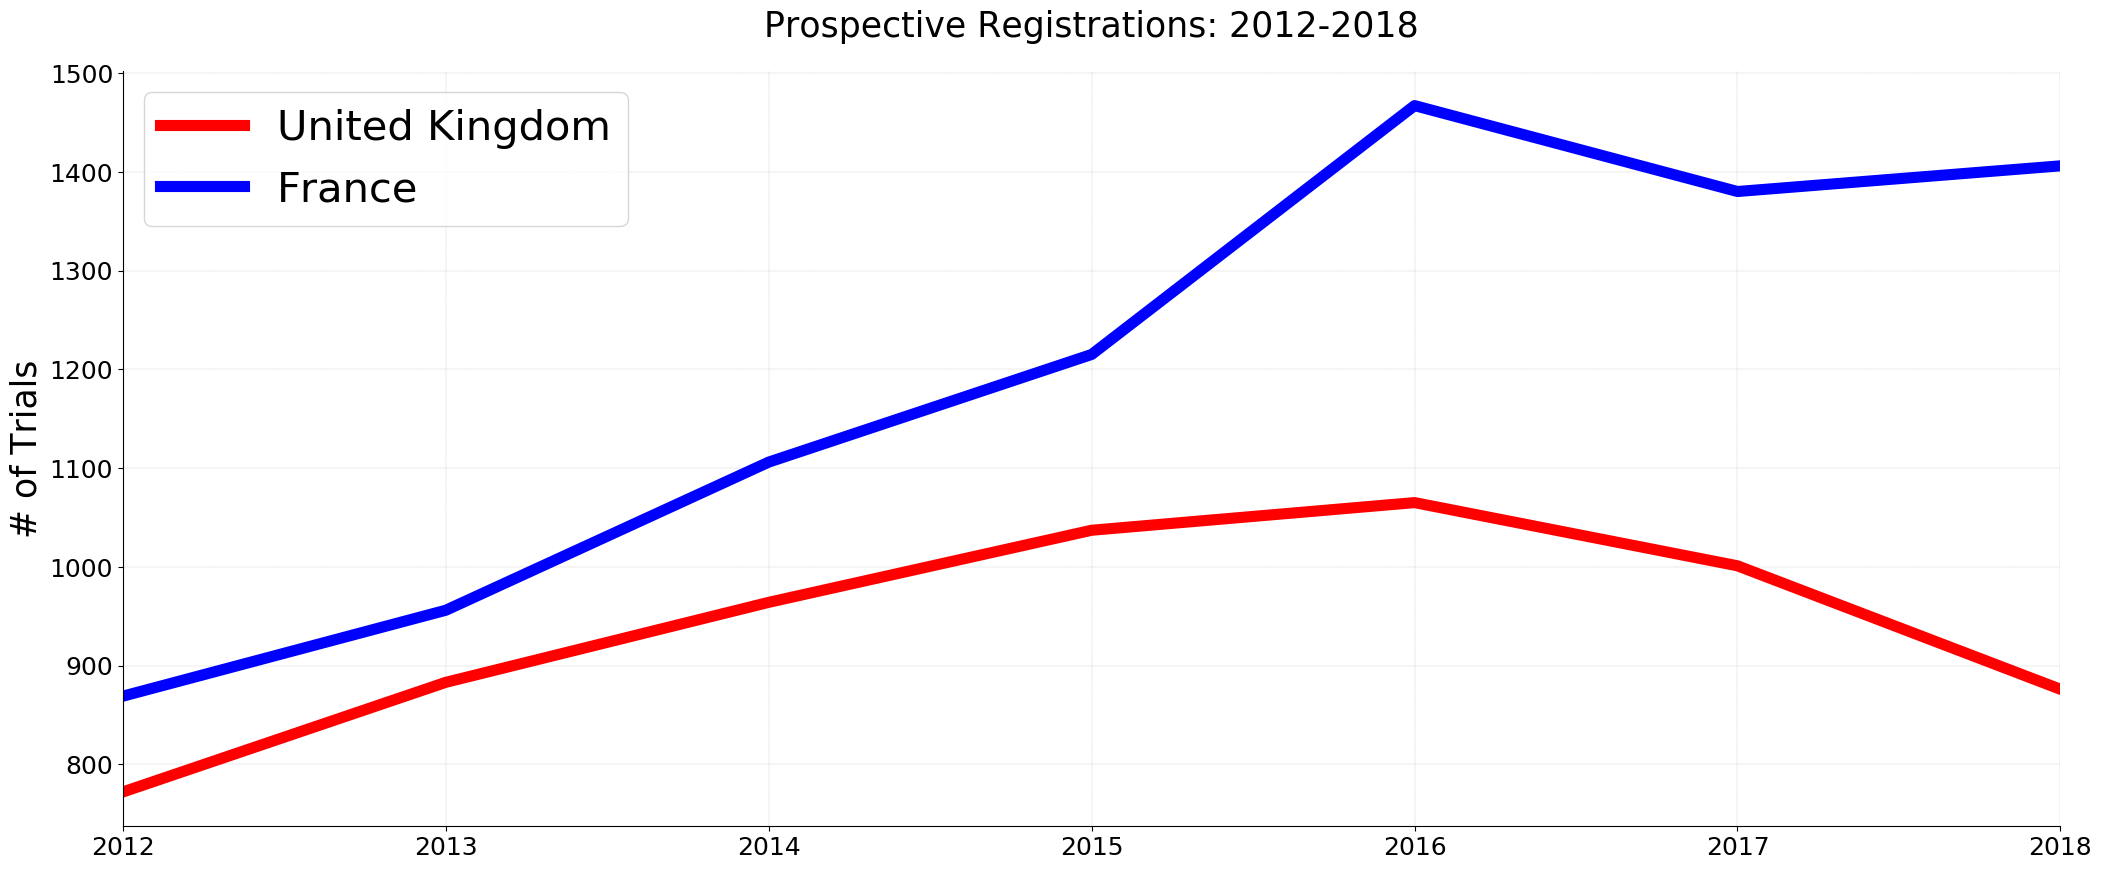

In [25]:
with_filt = (ctgov.study_status != "Withdrawn")
prosp_filt = (ctgov.start_date > ctgov.submitted_date)
prosp_reg_year = "Prospective Registrations: 2012-2018"
uk_qr = process_ctdata(ctgov[with_filt & prosp_filt],'United Kingdom', quarters=False, p1_filter=False)
fr_qr = process_ctdata(ctgov[with_filt & prosp_filt],'France', quarters=False, p1_filter=False)
graph(prosp_reg_year, uk_qr.submitted, fr_qr.submitted)

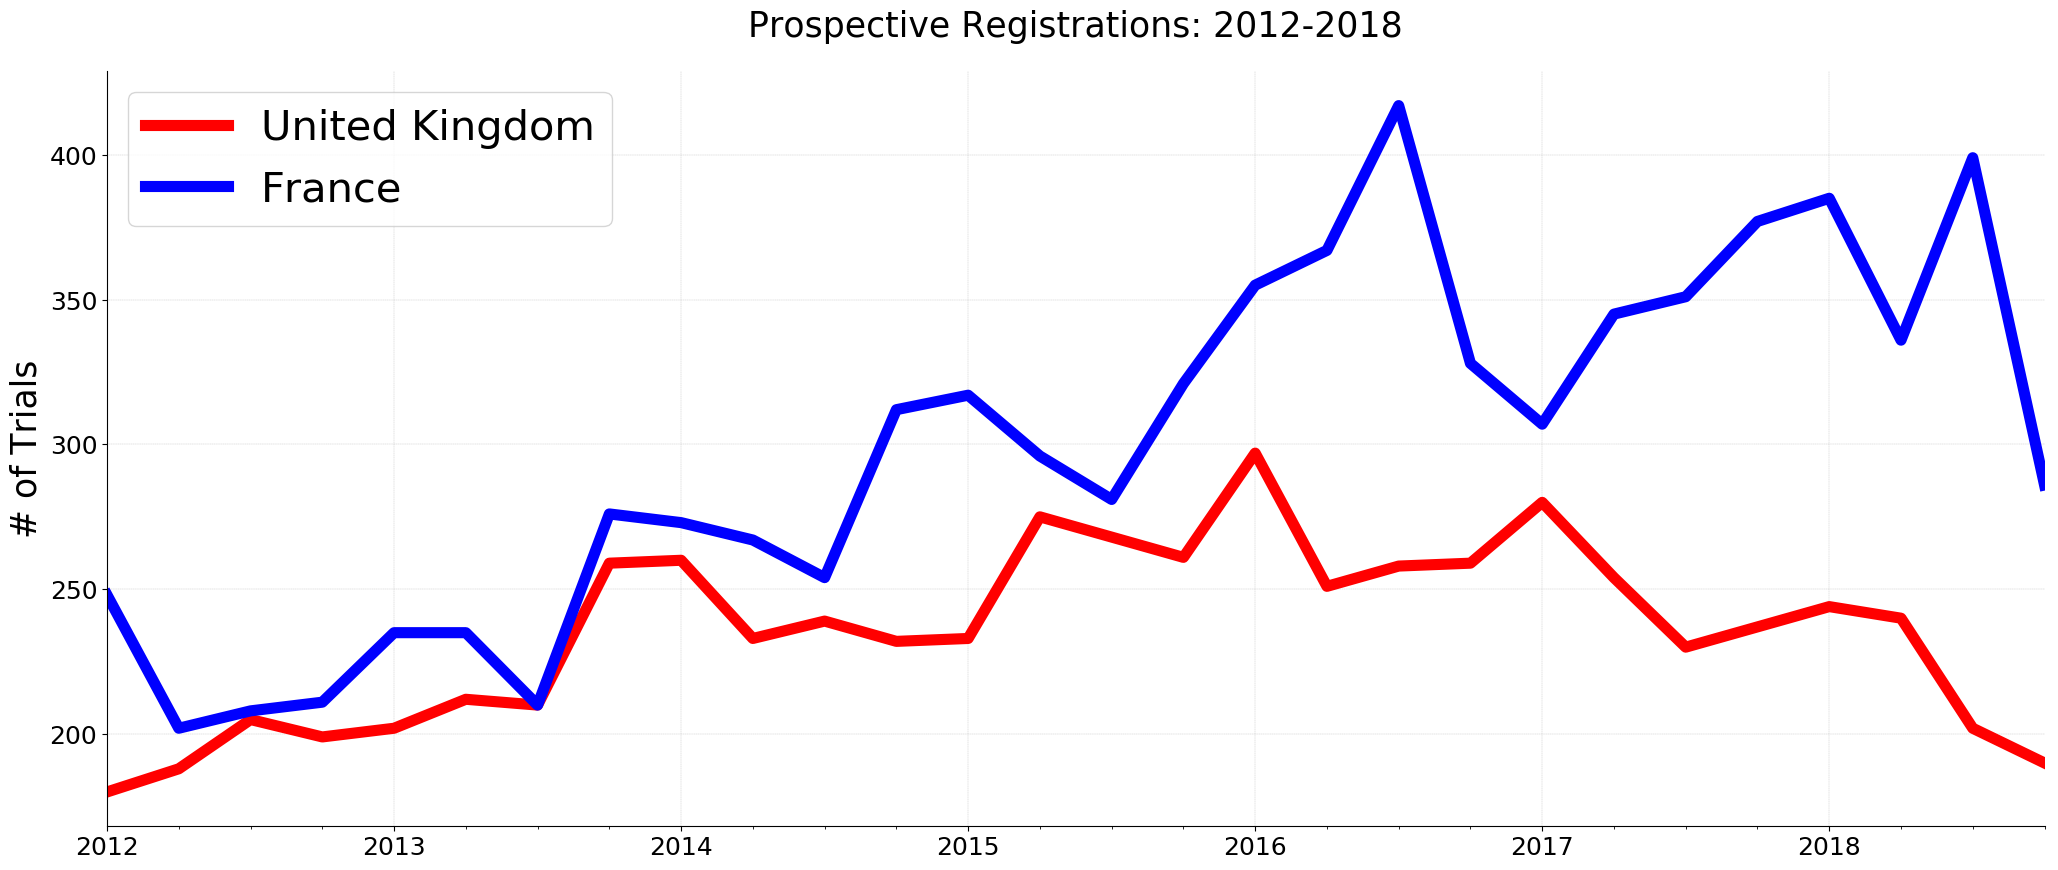

In [26]:
uk_qr = process_ctdata(ctgov[with_filt & prosp_filt],'United Kingdom', quarters=True, p1_filter=False)
fr_qr = process_ctdata(ctgov[with_filt & prosp_filt],'France', quarters=True, p1_filter=False)
graph(prosp_reg_year, uk_qr.submitted, fr_qr.submitted)

In [28]:
be_qr = process_ctdata(ctgov[with_filt & prosp_filt], 'Belgium', quarters=True, p1_filter=False)
de_qr = process_ctdata(ctgov[with_filt & prosp_filt], 'Germany', quarters=True, p1_filter=False)
es_qr = process_ctdata(ctgov[with_filt & prosp_filt], 'Spain', quarters=True, p1_filter=False)
it_qr = process_ctdata(ctgov[with_filt & prosp_filt], 'Italy', quarters=True, p1_filter=False)
nl_qr = process_ctdata(ctgov[with_filt & prosp_filt], 'Netherlands', quarters=True, p1_filter=False)
hu_qr = process_ctdata(ctgov[with_filt & prosp_filt], 'Hungary', quarters=True, p1_filter=False)

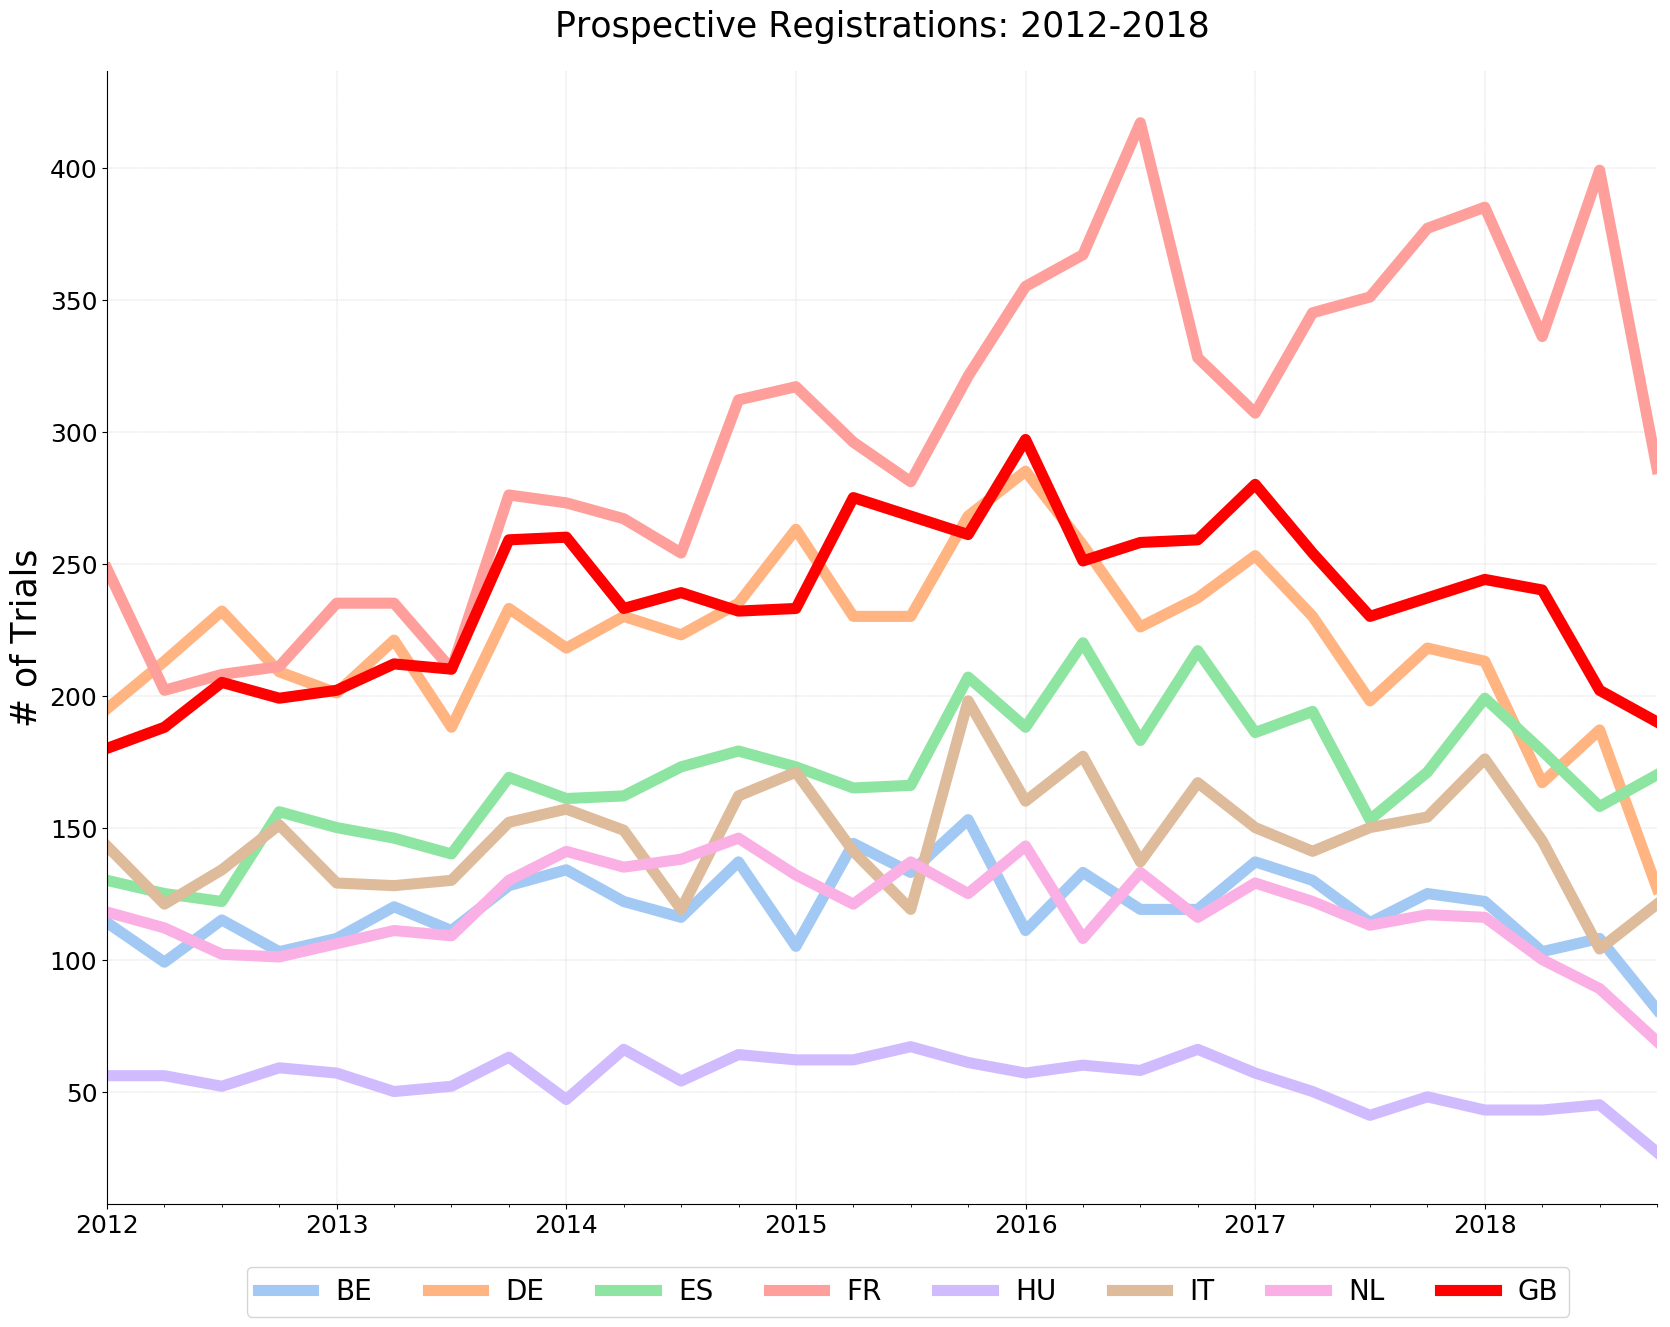

In [31]:
fig, ax = plt.subplots(figsize=(20,15), dpi = 100)
be_qr.submitted.plot(ax=ax, linewidth=8, color=colors[0])
de_qr.submitted.plot(ax=ax, linewidth=8, color=colors[1])
es_qr.submitted.plot(ax=ax, linewidth=8, color=colors[2])
fr_qrf.submitted.plot(ax=ax, linewidth=8, color=colors[3])
hu_qr.submitted.plot(ax=ax, linewidth=8, color=colors[4])
it_qr.submitted.plot(ax=ax, linewidth=8, color=colors[5])
nl_qr.submitted.plot(ax=ax, linewidth=8, color=colors[6])
uk_qrf.submitted.plot(ax=ax, linewidth=8, color='red')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.title(prosp_reg_year, pad=25, fontsize=25)
ax.xaxis.set_label_text('')
ax.yaxis.set_label_text('# of Trials', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(labels = ['BE', 'DE', 'ES', 'FR', 'HU', 'IT', 'NL', 'GB'], loc=(.09,-.1), ncol = 8, fontsize = 20)
ax.yaxis.grid(linestyle='--', linewidth=.25)
ax.xaxis.grid(linestyle='--', linewidth=.25)
plt.show()